# Generiert Graphiken für Skript

In [5]:
import BusinessAnalytics as BA
from BusinessAnalytics import get_stock_data, plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## DAX 1988 - 2022

In [6]:
dax = get_stock_data("^GDAXI", start="01-01-1987", end="31-07-2022")

In [7]:
idx = np.argmax(dax["Adj Close"])
dax.iloc[idx]

Date         2022-01-05 00:00:00
Open                 16177.44043
High                16285.349609
Low                 16161.719727
Close                   16271.75
Adj Close               16271.75
Volume                68244500.0
ticker                    ^GDAXI
Name: 8760, dtype: object

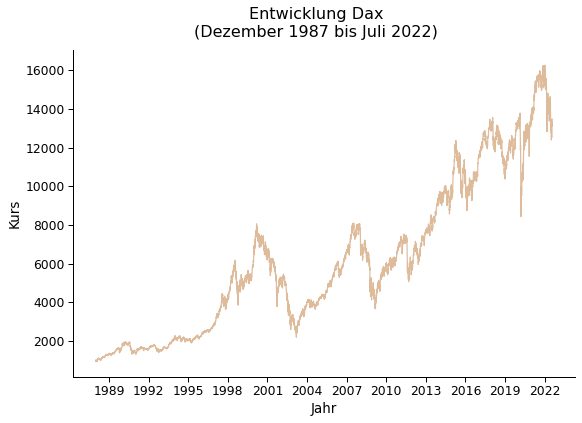

In [8]:
color = BA.plotting.COLORS[5]
ax = plot(data=dax, x="Date", y="Adj Close", 
     title="Entwicklung Dax\n(Dezember 1987 bis Juli 2022)", 
     ylabel="Kurs", xlabel="Jahr", show_legend=False,
     colors=color )

ax.xaxis.set_major_locator(mdates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.savefig("Dax.png", dpi=80)

In [9]:
start = 898
ende = 3453
dax.iloc[[start, ende]]["Adj Close"].pct_change()

898          NaN
3453    2.372615
Name: Adj Close, dtype: float64

In [10]:
start = pd.to_datetime("12.04.2007")
ende = pd.to_datetime("19.12.2008")
dax.set_index("Date")[start:ende]["Adj Close"]

4696/7808 - 1

-0.39856557377049184

## 6 fiktive Portfolien

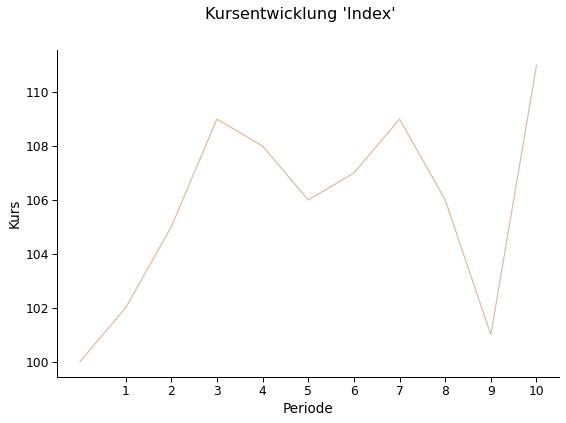

In [11]:
days = np.arange(0,11)
rets = np.array([ 0.00, 0.02, 0.03, 0.04, -0.01, 	-0.02, 0.01, 0.02, 	-0.03, -0.05,0.10 ])
start = 100
index = start * np.cumprod((1+rets))
data = pd.DataFrame({"Kurs": np.round(index), "Periode": days, "rt":rets})
ax = plot(data, x="Periode", y="Kurs", 
          show_legend=False, colors=color, title="Kursentwicklung 'Index'")
ax.set_xticks(days[1:])
ax.set_xticklabels(days[1:])
plt.savefig("Index_Beispiel.png", dpi=80)

In [12]:
def replace_first_row(_df, to_replace=np.nan, value=1):
    cols = _df.columns
    _df.iloc[0] = _df.iloc[0].replace(to_replace=to_replace, value=value)
    return _df

In [18]:
t_min = 5
n = len(data) - t_min + 1
data_new = (data
        .assign(**{f"Anlage_{i}":data["rt"].iloc[1:].add(1).shift(-i+1).cumprod() for i in np.arange(1,n)})
        .pipe(replace_first_row, np.nan, 1)
        #.melt(id_vars=["Periode", "Kurs", "rt"], var_name="Portfolio")
        )
data_new

,Kurs,Periode,rt,Anlage_1,Anlage_2,Anlage_3,Anlage_4,Anlage_5,Anlage_6
0,100.0,0,0.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,102.0,1,0.02,1.020000,1.030000,1.040000,0.990000,0.980000,1.010000
2,105.0,2,0.03,1.050600,1.071200,1.029600,0.970200,0.989800,1.030200
3,109.0,3,0.04,1.092624,1.060488,1.009008,0.979902,1.009596,0.999294
4,108.0,4,-0.01,1.081698,1.039278,1.019098,0.999500,0.979308,0.949329
5,106.0,5,-0.02,1.060064,1.049671,1.039480,0.969515,0.930343,1.044262
6,107.0,6,0.01,1.070664,1.070664,1.008296,0.921039,1.023377,NaN
7,109.0,7,0.02,1.092078,1.038545,0.957881,1.013143,NaN,NaN
8,106.0,8,-0.03,1.059315,0.986617,1.053669,NaN,NaN,NaN
9,101.0,9,-0.05,1.006350,1.085279,NaN,NaN,NaN,NaN


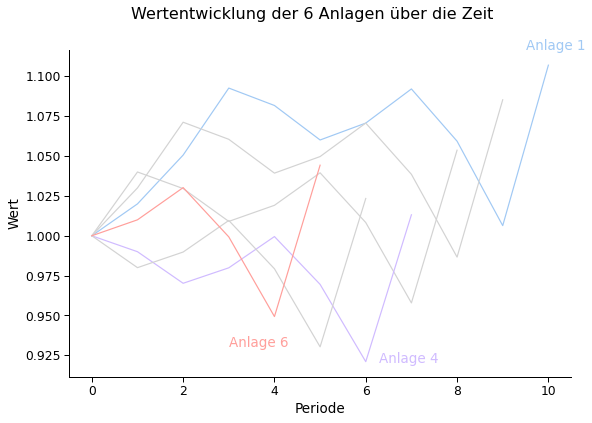

In [19]:
colors = BA.plotting.COLORS
ax = plot(data=data_new, x="Periode", y=[col for col in data_new.columns if "Anlage" in col], 
        colors=[colors[0], "lightgrey", "lightgrey", colors[4], "lightgrey", colors[3]], 
        show_legend=False, xlabel="Periode", ylabel="Wert", title="Wertentwicklung der 6 Anlagen über die Zeit")


xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.annotate("Anlage 1", (xmax-1, ymax), color=colors[0] )
ax.annotate("Anlage 4", (6.3, 0.92), color=colors[4] )
ax.annotate("Anlage 6", (3,0.93), color=colors[3])
plt.savefig("Anlagen_perf.png", dpi=80)

In [150]:
sum(data.query("Periode == 6")["Wert"] < 1)

2

## 10 zufällige Portfolios

In [22]:
def sample_data(data, n, t, replace=True):
    return np.random.choice(data, (n,t), replace=replace)

In [145]:
np.random.seed(123545)
n = 10
t = 10
smpl = sample_data(rets[1:], n, t)
cum_rets = np.column_stack((np.ones(n), np.cumprod(1+smpl, axis=1)))

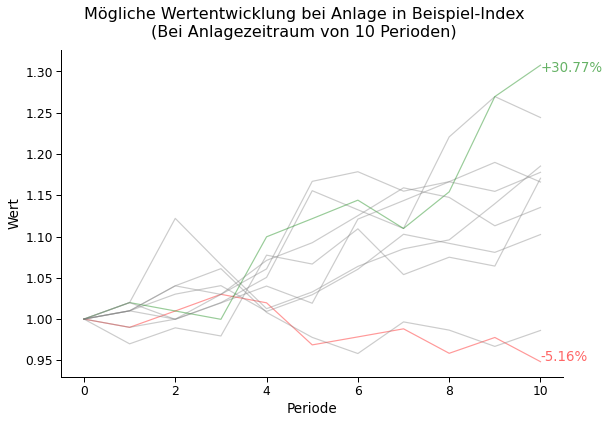

In [146]:
data = (pd.DataFrame(cum_rets.T, columns=[f"Anlage_{i}" for i in range(1,n+1)])
        .assign(Periode=np.arange(t+1))
        .melt(id_vars=["Periode"])
        .rename({"variable":"Anlage", "value":"Wert"}, axis=1)
        )
ax = plot(data=data, x="Periode", y="Wert", hue="Anlage", 
     title="Mögliche Wertentwicklung bei Anlage in Beispiel-Index\n(Bei Anlagezeitraum von 10 Perioden)",
     colors=["gray" for i in range(n)], 
     show_legend=False)

idx_max = np.argmax(cum_rets[:,-1])
idx_min = np.argmin(cum_rets[:,-1])

for i,l in enumerate(ax.lines):
    l.set_alpha(0.4)
    if i == idx_max: l.set_color("green")
    if i == idx_min: l.set_color("red")

ymin, ymax = ax.get_ylim()

ret_max = np.round((cum_rets[idx_max, -1] - 1)*100,2)
ax.annotate(f"+{ret_max}%", (10,ymax*0.98), color="green", alpha=0.6)
ret_min = np.round((cum_rets[idx_min, -1] - 1)*100,2)
ax.annotate(f"-{abs(ret_min)}%", (10,ymin*1.02), color="red", alpha=0.6)
plt.savefig("Anlagen_random.png", dpi=80)

## 1.000 zufällige Portfolien

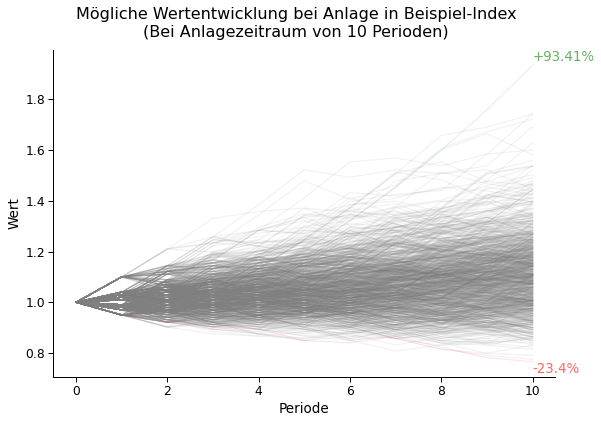

In [105]:
np.random.seed(123545)
n = 1000
t = 10
smpl = sample_data(rets[1:], n, t)
cum_rets = np.column_stack((np.ones(n), np.cumprod(1+smpl, axis=1)))
data = (pd.DataFrame(cum_rets.T, columns=[f"Anlage_{i}" for i in range(1,n+1)])
        .assign(Periode=np.arange(t+1))
        .melt(id_vars=["Periode"])
        .rename({"variable":"Anlage", "value":"Wert"}, axis=1)
        )
ax = plot(data=data, x="Periode", y="Wert", hue="Anlage", 
     title="Mögliche Wertentwicklung bei Anlage in Beispiel-Index\n(Bei Anlagezeitraum von 10 Perioden)",
     colors=["gray" for i in range(n)], 
     show_legend=False)

idx_max = np.argmax(cum_rets[:,-1])
idx_min = np.argmin(cum_rets[:,-1])

for i,l in enumerate(ax.lines):
    l.set_alpha(0.1)
    if i == idx_max: l.set_color("green")
    if i == idx_min: l.set_color("red")

ymin, ymax = ax.get_ylim()

ret_max = np.round((cum_rets[idx_max, -1] - 1)*100,2)
ax.annotate(f"+{ret_max}%", (10,ymax*0.98), color="green", alpha=0.6)
ret_min = np.round((cum_rets[idx_min, -1] - 1)*100,2)
ax.annotate(f"-{abs(ret_min)}%", (10,ymin*1.02), color="red", alpha=0.6)
plt.savefig("Anlagen_random_big.png", dpi=80)

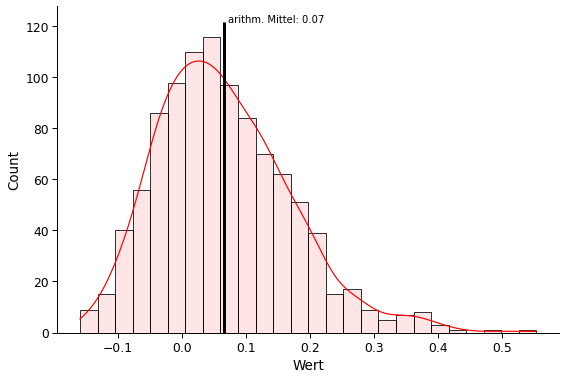

In [144]:
import seaborn as sns
data_hist = (data
             .query("Periode == 6")
             .assign(Wert=lambda _df: _df["Wert"] - 1)
            )
mu = data_hist["Wert"].mean()
ax = sns.histplot(data=data_hist, x="Wert", color="red", alpha=0.1, kde=True)
ymin, ymax = ax.get_ylim()
ax.lines[0].set_color("red")
ax.vlines(x=mu,color="black", linewidth=3, ymin=ymin, ymax=ymax)
ax.annotate(f"arithm. Mittel: {np.round(mu,2)}", (mu*1.1,ymax), **{"fontsize": 10});

In [ ]:

ax = plot(data=data_hist, x="Wert", plot_type="hist", 
     ylabel="Häufigkeit", 
     xlabel="Rendite in ct",
     show_legend=False)
ax.set_alpha(0.4)

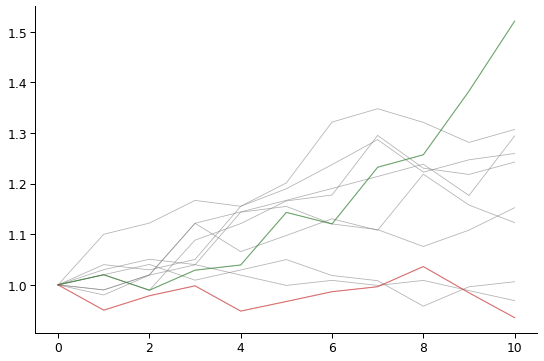

In [27]:
fig, ax = plt.subplots()
ax.plot(cum_rets.T, color="gray", linewidth=0.8, alpha=0.6);
ax.plot(cum_rets[idx_max,:], color="green", alpha=0.4)
ax.plot(cum_rets[idx_min,:], color="red", alpha=0.4)


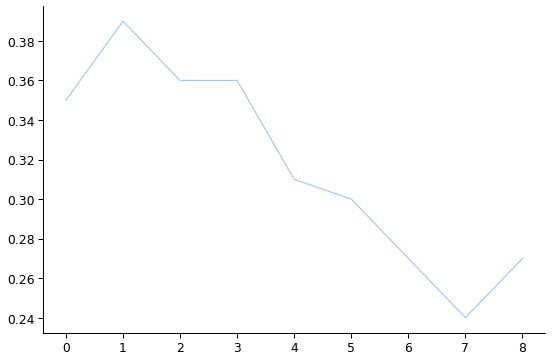

In [509]:
probs = []
for i in np.arange(1,t):
    p = sum(smpl[:,i] < 1 ) / n
    probs.append(p)
plt.plot(probs)

In [511]:
np.r_?

Type:        RClass
String form: <numpy.lib.index_tricks.RClass object at 0x7f9998f7e940>
Length:      0
File:        ~/opt/anaconda3/envs/coding4class/lib/python3.9/site-packages/numpy/lib/index_tricks.py
Docstring:  
Translates slice objects to concatenation along the first axis.

This is a simple way to build up arrays quickly. There are two use cases.

1. If the index expression contains comma separated arrays, then stack
   them along their first axis.
2. If the index expression contains slice notation or scalars then create
   a 1-D array with a range indicated by the slice notation.

If slice notation is used, the syntax ``start:stop:step`` is equivalent
to ``np.arange(start, stop, step)`` inside of the brackets. However, if
``step`` is an imaginary number (i.e. 100j) then its integer portion is
interpreted as a number-of-points desired and the start and stop are
inclusive. In other words ``start:stop:stepj`` is interpreted as
``np.linspace(start, stop, step, endpoint=1)`` insid

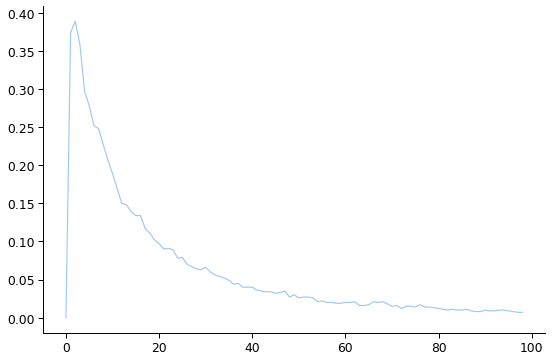

In [484]:
plt.plot(probs)

In [1]:
%history -g -f anyfilename


In [1]:
1 * (1.01) * (0.95) * 0.95

0.9115249999999999